# **SETUP**

1) continue Image Classification problem from previous class which aims to classify microscopy images into good, empty or blurred by: 
1. gathering ~1000 samples per class for training the model; 
2. using https://supervise.ly for image augmentation to generate more samples;
3. using CNN - AlexNet

2) denoise blurred images using auto-encoder
1. please see https://blog.keras.io/building-autoencoders-in-keras.html
2. Simple structure could be: blurry input images -> feed into CNN (this could be transfer learning) -> train x - noise image  y - clean image -> Fully connected NN -> reconstructed clean image

3) track patches from fluorescence images and use a visualization tool


In [1]:
%tensorflow_version 1.x
import tensorflow as tf
import keras
from platform import python_version

TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
keras.__version__

'2.2.5'

In [3]:
tf.__version__

'1.15.2'

In [4]:
print(python_version())

3.6.9


In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Apr  8 15:04:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [6]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [7]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras import applications
import tensorflow as tf
from tqdm import tqdm
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import random
from shutil import copyfile
import os
import gc
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras import backend as K

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import style
import seaborn as sns
from keras.callbacks import ModelCheckpoint
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [10]:
from google.colab import drive
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [11]:
%cd /content/drive/My Drive/DeepLearning/Project/dataset1

!ls

/content/drive/My Drive/DeepLearning/Project/dataset1
'autoencoder model'   empty   test     val	   X_good      y_good
 blurred	      good    train    X_blurred   y_blurred
 blurred2	      good2   train1   X_empty	   y_empty


# **Data Preparation**

In [0]:
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
%matplotlib inline
# Where to save the figures
PROJECT_ROOT_DIR = "."
import os
import numpy as np
import shutil

In [0]:
# # Creating Train / Val / Test folders (One time use)
images_split = "/content/drive/My Drive/DeepLearning/Project/dataset1"
good = "/good"
empty = "/empty"
blurred = "/blurred"

if os.path.exists(images_split +'/train' + good):
    shutil.rmtree(images_split +'/train' + good)
os.makedirs(images_split +'/train' + good)

if os.path.exists(images_split +'/train1' + good):
    shutil.rmtree(images_split +'/train1' + good)
os.makedirs(images_split +'/train1' + good)

if os.path.exists(images_split +'/test' + good):
    shutil.rmtree(images_split +'/test' + good)
os.makedirs(images_split +'/test' + good)

if os.path.exists(images_split +'/val' + good):
    shutil.rmtree(images_split +'/val' + good)
os.makedirs(images_split +'/val' + good)

if os.path.exists(images_split +'/train' + empty):
    shutil.rmtree(images_split +'/train' + empty)
os.makedirs(images_split +'/train' + empty)

if os.path.exists(images_split +'/train1' + empty):
    shutil.rmtree(images_split +'/train1' + empty)
os.makedirs(images_split +'/train1' + empty)

if os.path.exists(images_split +'/test' + empty):
    shutil.rmtree(images_split +'/test' + empty)
os.makedirs(images_split +'/test' + empty)

if os.path.exists(images_split +'/val' + empty):
    shutil.rmtree(images_split +'/val' + empty)
os.makedirs(images_split +'/val' + empty)

if os.path.exists(images_split +'/train' + blurred):
    shutil.rmtree(images_split +'/train' + blurred)
os.makedirs(images_split +'/train' + blurred)

if os.path.exists(images_split +'/train1' + blurred):
    shutil.rmtree(images_split +'/train1' + blurred)
os.makedirs(images_split +'/train1' + blurred)


if os.path.exists(images_split +'/test' + blurred):
    shutil.rmtree(images_split +'/test' + blurred)
os.makedirs(images_split +'/test' + blurred)

if os.path.exists(images_split +'/val' + blurred):
    shutil.rmtree(images_split +'/val' + blurred)
os.makedirs(images_split +'/val' + blurred)



In [0]:
# Creating partitions of the data after shuffeling
sra = "/content/drive/My Drive/DeepLearning/Project/dataset1/good"
srb = "/content/drive/My Drive/DeepLearning/Project/dataset1/empty"
src = "/content/drive/My Drive/DeepLearning/Project/dataset1/blurred"

srx = "/content/drive/My Drive/DeepLearning/Project/dataset1/train/good"
sry = "/content/drive/My Drive/DeepLearning/Project/dataset1/train/empty"
srz = "/content/drive/My Drive/DeepLearning/Project/dataset1/train/blurred"

In [6]:
#Good train_test split
allFileNames = os.listdir(sra)
np.random.shuffle(allFileNames)
test_FileNames, train_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.25)])

train_FileNames = [sra+'/'+ name for name in train_FileNames.tolist()]
test_FileNames = [sra+'/' + name for name in test_FileNames.tolist()]

print('Training: ', len(train_FileNames))
print('Testing: ', len(test_FileNames))

# Copy-pasting images
for name in train_FileNames:
    shutil.copy(name, "/content/drive/My Drive/DeepLearning/Project/dataset1/train/good")

for name in test_FileNames:
    shutil.copy(name, "/content/drive/My Drive/DeepLearning/Project/dataset1/test/good")

Training:  1872
Testing:  624


In [7]:
#Good train_val split
allFileNames = os.listdir(srx)
np.random.shuffle(allFileNames)
test_FileNames, train_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.25)])

train_FileNames = [srx+'/'+ name for name in train_FileNames.tolist()]
test_FileNames = [srx+'/' + name for name in test_FileNames.tolist()]

print('Training: ', len(train_FileNames))
print('Validating: ', len(test_FileNames))

# Copy-pasting images
for name in train_FileNames:
    shutil.copy(name, "/content/drive/My Drive/DeepLearning/Project/dataset1/train1/good")

for name in test_FileNames:
    shutil.copy(name, "/content/drive/My Drive/DeepLearning/Project/dataset1/val/good")

Training:  1404
Validating:  468


In [9]:
#Empty train_test split
allFileNames = os.listdir(srb)
np.random.shuffle(allFileNames)
test_FileNames, train_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.25)])

train_FileNames = [srb+'/'+ name for name in train_FileNames.tolist()]
test_FileNames = [srb+'/' + name for name in test_FileNames.tolist()]

print('Training: ', len(train_FileNames))
print('Testing: ', len(test_FileNames))

# Copy-pasting images
for name in train_FileNames:
    shutil.copy(name, "/content/drive/My Drive/DeepLearning/Project/dataset1/train/empty")

for name in test_FileNames:
    shutil.copy(name, "/content/drive/My Drive/DeepLearning/Project/dataset1/test/empty")

Training:  1098
Testing:  366


In [10]:
#Empty train_val split
allFileNames = os.listdir(sry)
np.random.shuffle(allFileNames)
test_FileNames, train_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.25)])

train_FileNames = [sry+'/'+ name for name in train_FileNames.tolist()]
test_FileNames = [sry+'/' + name for name in test_FileNames.tolist()]

print('Training: ', len(train_FileNames))
print('Validating: ', len(test_FileNames))

# Copy-pasting images
for name in train_FileNames:
    shutil.copy(name, "/content/drive/My Drive/DeepLearning/Project/dataset1/train1/empty")

for name in test_FileNames:
    shutil.copy(name, "/content/drive/My Drive/DeepLearning/Project/dataset1/val/empty")

Training:  824
Validating:  274


In [12]:
#Blurred train_test split
allFileNames = os.listdir(src)
np.random.shuffle(allFileNames)
test_FileNames, train_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.25)])

train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

print('Training: ', len(train_FileNames))
print('Testing: ', len(test_FileNames))

# Copy-pasting images
for name in train_FileNames:
    shutil.copy(name, "/content/drive/My Drive/DeepLearning/Project/dataset1/train/blurred")

for name in test_FileNames:
    shutil.copy(name, "/content/drive/My Drive/DeepLearning/Project/dataset1/test/blurred")

Training:  2304
Testing:  768


In [13]:
#Blurred train_val split
allFileNames = os.listdir(srz)
np.random.shuffle(allFileNames)
test_FileNames, train_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.25)])

train_FileNames = [srz+'/'+ name for name in train_FileNames.tolist()]
test_FileNames = [srz+'/' + name for name in test_FileNames.tolist()]

print('Training: ', len(train_FileNames))
print('Validating: ', len(test_FileNames))

# Copy-pasting images
for name in train_FileNames:
    shutil.copy(name, "/content/drive/My Drive/DeepLearning/Project/dataset1/train1/blurred")

for name in test_FileNames:
    shutil.copy(name, "/content/drive/My Drive/DeepLearning/Project/dataset1/val/blurred")

Training:  1728
Validating:  576


In [13]:
#Resize images to 224 x 224
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dir = "/content/drive/My Drive/DeepLearning/Project/dataset1/train1/"
validation_dir = "/content/drive/My Drive/DeepLearning/Project/dataset1/val/"
test_dir = "/content/drive/My Drive/DeepLearning/Project/dataset1/test/"

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

Found 3956 images belonging to 3 classes.
Found 1318 images belonging to 3 classes.
Found 1758 images belonging to 3 classes.


# **BASE MODEL AlexNet**

### AlexNet Architecture
Import AlexNet; adjust output shape to 3

In [14]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np
np.random.seed(1000)
#Instantiate an empty model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(4096, input_shape=(224*224*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))

# 2nd Fully Connected Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))

# 3rd Fully Connected Layer
model.add(Dense(1000))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))

# Output Layer - changed output shape to 3
model.add(Dense(3))
model.add(Activation('softmax'))

model.summary()

# Compile the model

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.00005), metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_2 (Activation)    (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         


### Early Stopping

In [0]:
es = EarlyStopping(monitor='val_acc', verbose=2, patience=25)
filepath = "./modelAlexNet_7.h5"
mc = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)

### Train Model

In [17]:
#Couldn't do an hyperparameter tuning/model optimization due to RAM limitations in colab :/
new_grid_1 = model.fit(train_generator, validation_data = validation_generator, epochs = 30, verbose=2, callbacks=[es,mc])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/30





 - 1454s - loss: 0.7709 - acc: 0.5453 - val_loss: 0.6061 - val_acc: 0.6275

Epoch 00001: val_acc improved from -inf to 0.62747, saving model to ./modelAlexNet_7.h5
Epoch 2/30
 - 58s - loss: 0.6476 - acc: 0.6174 - val_loss: 0.5949 - val_acc: 0.6366

Epoch 00002: val_acc improved from 0.62747 to 0.63657, saving model to ./modelAlexNet_7.h5
Epoch 3/30
 - 58s - loss: 0.6058 - acc: 0.6204 - val_loss: 0.5929 - val_acc: 0.6737

Epoch 00003: val_acc improved from 0.63657 to 0.67375, saving model to ./modelAlexNet_7.h5
Epoch 4/30
 - 58s - loss: 0.5816 - acc: 0.6379 - val_loss: 0.5670 - val_acc: 0.6768

Epoch 00004: val_acc improved from 0.67375 to 0.67678, saving model to ./modelAlexNet_7.h5
Epoch 5/30
 - 58s - loss: 0.5585 - acc: 0.6415 - val_loss: 0.5593 - val_acc: 0.6775

Epoch 00005: val_acc improved from 0.67678 to 0.67754, saving model to ./modelAlexNet_7.h5
Epoch 6/30
 - 58s -

### Load saved model and Evaluate

In [18]:
from keras.models import load_model
import numpy
import os

%cd /content/drive/My Drive/DeepLearning/Project/dataset1

/content/drive/My Drive/DeepLearning/Project/dataset1


In [19]:
final_model_AlexNet = tf.keras.models.load_model('./modelAlexNet_7.h5')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [22]:
# evaluate the model on validation set
val_scores = []
val_scores_1 = final_model_AlexNet.evaluate(validation_generator, verbose=0)
print("%s: %.2f%%" % (final_model_AlexNet.metrics_names[1], val_scores_1[1]*100))
val_scores.append(val_scores_1[1] * 100)

acc: 81.71%


In [23]:
# evaluate the model
finalscores = []
final_scores_1 = final_model_AlexNet.evaluate(test_generator, verbose=0)
print("%s: %.2f%%" % (final_model_AlexNet.metrics_names[1], final_scores_1[1]*100))
finalscores.append(final_scores_1[1] * 100)

acc: 82.03%


In [34]:
# Predict class
predictions = model.predict_generator(test_generator)
# Get most likely class
predicted_classes = numpy.argmax(predictions, axis=1)
print(predictions)

[[9.8121554e-01 2.3842750e-04 1.8546091e-02]
 [9.8326862e-01 1.3657764e-04 1.6594740e-02]
 [5.7742896e-04 1.1633628e-04 9.9930620e-01]
 ...
 [6.9402053e-09 1.0000000e+00 3.8706975e-09]
 [4.7828825e-03 4.0063084e-04 9.9481648e-01]
 [9.9103010e-01 1.9550405e-04 8.7743187e-03]]


In [0]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   


In [60]:
import sklearn
from sklearn import metrics

report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   


              precision    recall  f1-score   support

     blurred       0.45      0.35      0.39       768
       empty       0.25      0.25      0.25       366
        good       0.36      0.46      0.40       624

    accuracy                           0.37      1758
   macro avg       0.35      0.35      0.35      1758
weighted avg       0.37      0.37      0.37      1758



In [0]:
import itertools    
categorical_preds = pd.DataFrame(predicted_classes).idxmax(axis=1)
confusion_matrix = sklearn.metrics.confusion_matrix(true_classes, predicted_classes)

#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes, 
                          normalize=False, 
                          title="Confusion matrix",
                          cmap=plt.cm.Blues):
 
#Add Normalization Option
#  ‘’’prints pretty confusion metric with normalization option ‘’’
   if normalize:
     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     print('Normalized confusion matrix')
   else:
     print('Confusion matrix, without normalization')
 
# print(cm)
   plt.imshow(cm, interpolation='nearest', cmap=cmap)
   plt.title(title)
   plt.colorbar()
   tick_marks = np.arange(len(classes))
   plt.xticks(tick_marks, classes, rotation=45)
   plt.yticks(tick_marks, classes)
 
   fmt = '.2f' if normalize else 'd'
   thresh = cm.max() / 2.
   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
 
   plt.tight_layout()
   plt.ylabel('True label')
   plt.xlabel('Predicted label') 

Normalized confusion matrix


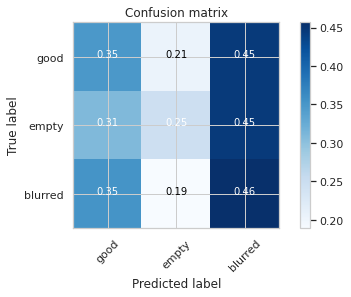

In [68]:
plot_confusion_matrix(confusion_matrix,['good','empty','blurred'], normalize = True)